This notebook demonstrates use of our linear approximation for a multiplicative functional perturbation 

In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp

from numpy.polynomial.hermite import hermgauss

import paragami

# BNP sensitivity libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
from bnpgmm_runjingdev import utils_lib
from bnpgmm_runjingdev import gmm_stick_influence as influence_lib

from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib 
from bnpmodeling_runjingdev import cluster_quantities_lib as cluster_lib


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles
from tqdm import tqdm

import json 

/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

# Load data

We load and plot the iris dataset

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

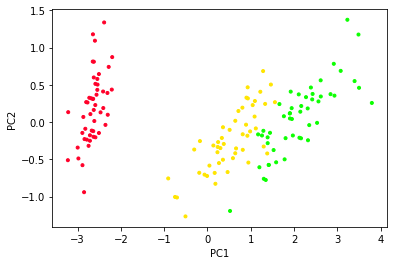

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load model

### Get prior 

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

In [6]:
print(prior_params_dict)

{'alpha': DeviceArray([3.], dtype=float64), 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


In [7]:
# DP prior parameter 
prior_params_dict['alpha'] = 12

### Variational parameters

In [8]:
k_approx = 30

In [9]:
# Gauss-Hermite points
gh_deg = 20
gh_loc, gh_weights = hermgauss(gh_deg)


In [10]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [11]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray(1889.86954163, dtype=float64)

# Optimize

### Kmeans

In [12]:
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 2391)
                                                # seed = 32423)

### Run CAVI

In [13]:
vb_params_dict = deepcopy(init_vb_params_dict)

In [14]:
vb_opt_dict, e_z_opt = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False, 
                                            x_tol = 1e-3)

Compiling CAVI update functions ... 
CAVI compile time: 4.26sec

Running CAVI ... 
done. num iterations = 90
stick_time: 0.75sec
cluster_time: 0.59sec
e_z_time: 0.0176sec
**CAVI time: 1.46sec**


In [15]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [16]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


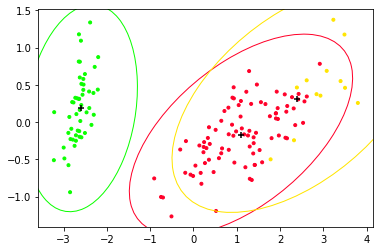

In [17]:
# results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)

# Set up linear response derivatives

In [18]:
# this log phi is just a place-holder

def null_pert(logit_v):
    return(logit_v * 0.0)

In [19]:
# set up objective functions

# this just returns the KL at epsilon = 0 
# (no perturbation)
# NOTE this function doesn't actually depend on epsilon
get_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: gmm_lib.get_kl(features, 
                                            params,
                                            prior_params_dict, 
                                            gh_loc,
                                            gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)

# the only part of the KL that depends on epsilon
def get_e_log_perturbation(log_phi, vb_params_dict, epsilon, gh_loc, gh_weights): 
    return func_sens_lib.get_e_log_perturbation(log_phi,
                            vb_params_dict['stick_params']['stick_propn_mean'],
                            vb_params_dict['stick_params']['stick_propn_info'],
                            epsilon, gh_loc, gh_weights, sum_vector=True)


hyper_par_objective_fun = paragami.FlattenFunctionInput(
    lambda params, epsilon: get_e_log_perturbation(null_pert, 
                                                    params,
                                                    epsilon,
                                                    gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)

In [20]:
# set up linear approximation class
epsilon0 = np.array([0.])

epsilon_sens = \
    HyperparameterSensitivityLinearApproximation(
        objective_fun = get_vb_loss, 
        opt_par_value = vb_opt, 
        hyper_par_value0 = epsilon0, 
        hyper_par_objective_fun = hyper_par_objective_fun)

Compiling hessian solver ...
Hessian solver compile time: 46.6403sec

Compiling cross hessian...
Cross-hessian compile time: 0.306152sec

LR sensitivity time: 0.0111213sec



# Compute influence function

In [21]:
influence_fun = influence_lib.InfluenceFunction(vb_opt, 
                           vb_params_paragami, 
                           epsilon_sens.hessian_solver,
                           prior_params_dict['alpha'])

In [22]:
logit_theta = np.linspace(-5, 5, 60)
theta = sp.special.expit(logit_theta)

In [23]:
influence_operator = influence_fun.get_influence(theta)

In [24]:
def g(vb_free_params, vb_params_paragami): 
    e_z = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                      vb_params_paragami.fold(vb_free_params, free = True), 
                                      gh_loc, gh_weights)
    
    return cluster_lib.get_e_num_clusters_from_ez(e_z)

In [25]:
get_grad_g = jax.jacobian(g, argnums = 0)
grad_g = get_grad_g(vb_opt, vb_params_paragami)

In [26]:
influence = np.dot(grad_g, influence_operator)

Text(0.5, 0, 'theta')

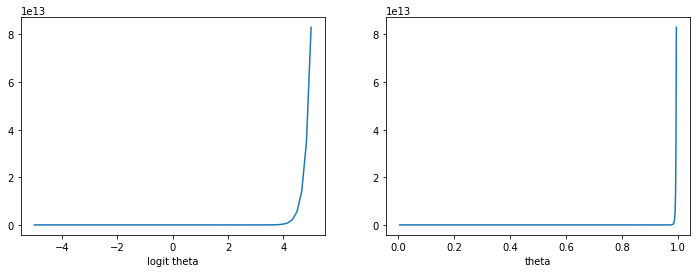

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4)) 
ax[0].plot(logit_theta, influence)
ax[0].set_xlabel('logit theta')

ax[1].plot(theta, influence)
ax[1].set_xlabel('theta')

Text(0.5, 0, 'theta')

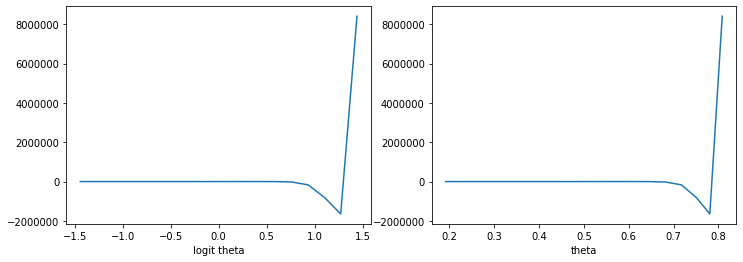

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4)) 

dom_bool = np.abs(logit_theta) < 1.5
ax[0].plot(logit_theta[dom_bool], influence[dom_bool])
ax[0].set_xlabel('logit theta')

ax[1].plot(theta[dom_bool], influence[dom_bool])
ax[1].set_xlabel('theta')

In [29]:
k_approx

30

In [30]:
log_qk = influence_fun.get_log_qk(theta, influence_fun.vb_opt)

In [31]:
log_qk.shape

(29, 60)

In [32]:
log_beta_prior = influence_lib.get_log_beta_prior(theta, prior_params_dict['alpha'])

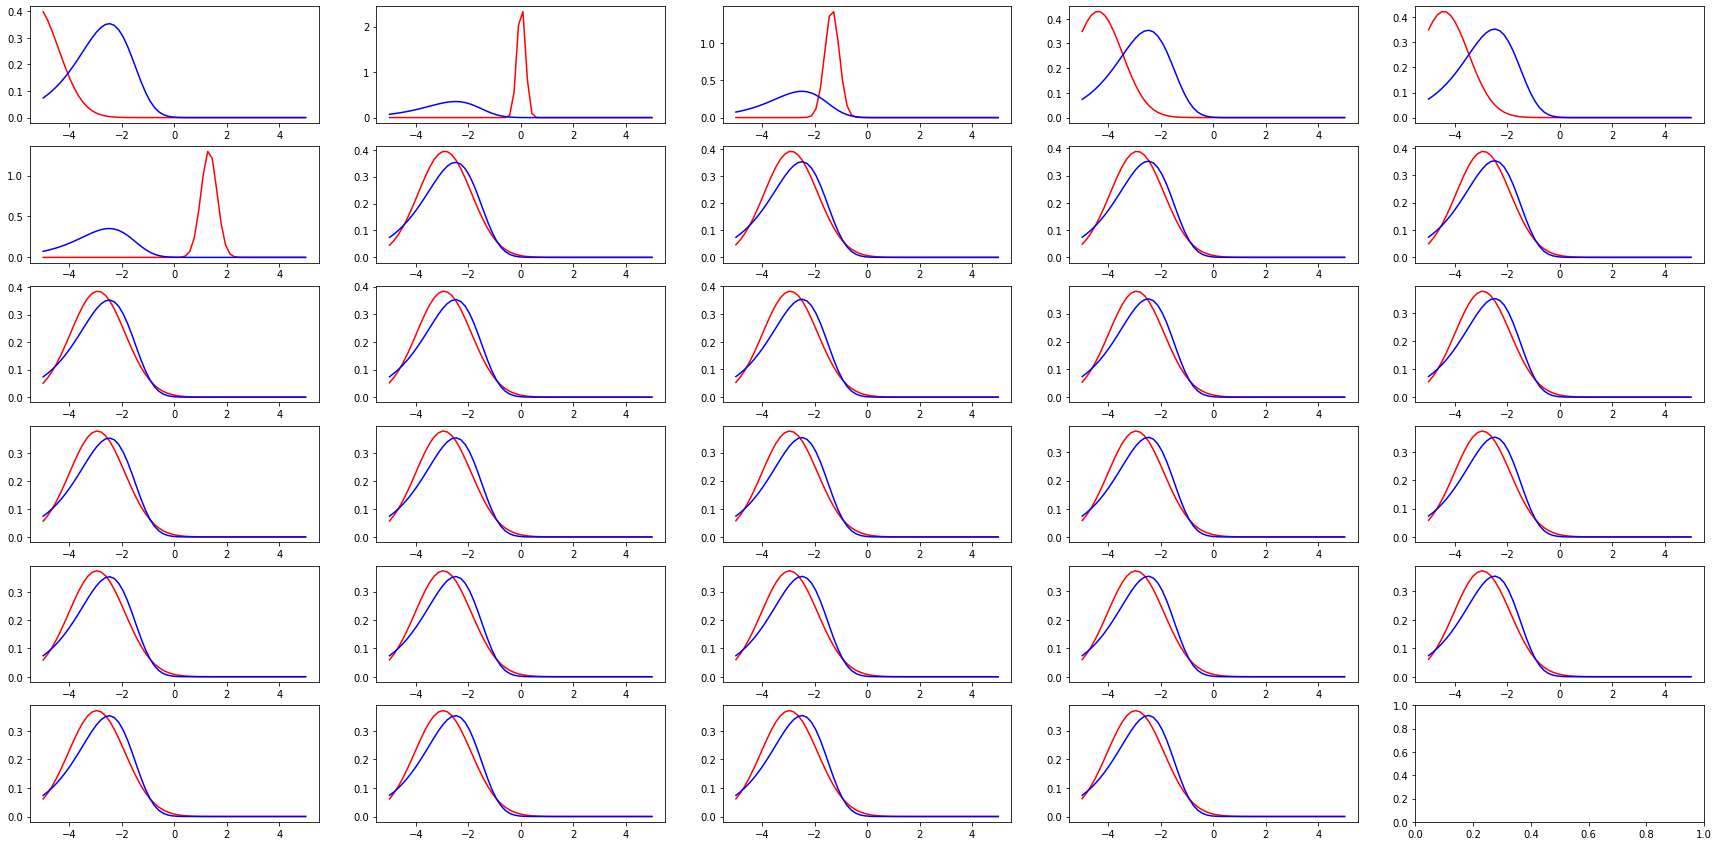

In [45]:
fig, ax = plt.subplots(6, 5, figsize = (30, 15)) 

for k in range(k_approx - 1): 
    ax[k // 5, k % 5].plot(logit_theta, np.exp(log_qk[k, :]) * theta * (1 - theta), color = 'red')
    ax[k // 5, k % 5].plot(logit_theta, np.exp(log_beta_prior) * theta * (1 - theta), color = 'blue')

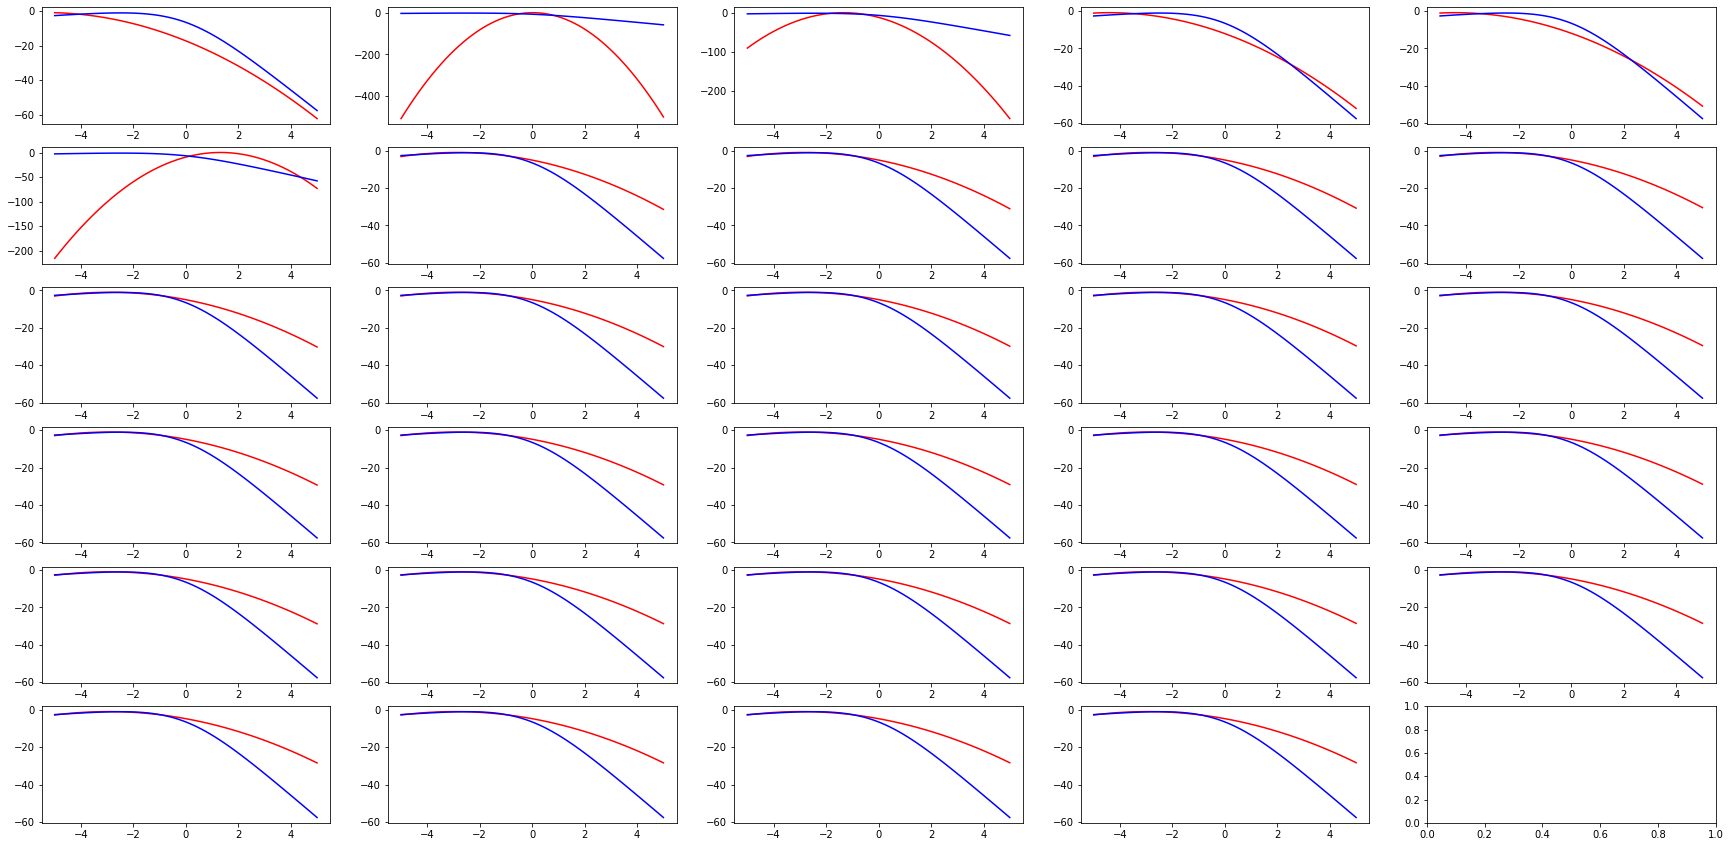

In [46]:
fig, ax = plt.subplots(6, 5, figsize = (30, 15)) 

for k in range(k_approx - 1): 
    ax[k // 5, k % 5].plot(logit_theta, log_qk[k, :] + np.log(theta) + np.log(1 - theta), color = 'red')
    ax[k // 5, k % 5].plot(logit_theta, log_beta_prior + np.log(theta) + np.log(1 - theta), color = 'blue')

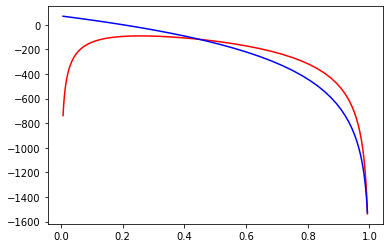

In [35]:
plt.plot(theta, log_qk.sum(0), color = 'red')
plt.plot(theta, log_beta_prior * (k_approx - 1), color = 'blue')

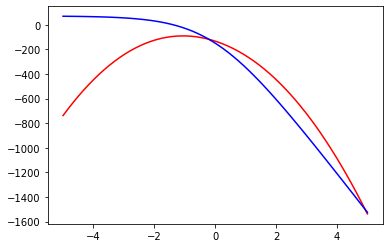

In [36]:
plt.plot(logit_theta, log_qk.sum(0), color = 'red')
plt.plot(logit_theta, log_beta_prior * (k_approx - 1), 
         color = 'blue')